In [20]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
np.random.seed(42)
random.seed(42)


In [21]:
DATASET_DIR = r'C:\Users\farza\Desktop\Downloads\CVPR\animals'
CATEGORIES = os.listdir(DATASET_DIR)
IMG_SIZE = 32
NUM_IMAGES = 100

# === LOAD AND SAMPLE 100 RANDOM IMAGES ===
all_data = []
for category in CATEGORIES:
    path = os.path.join(DATASET_DIR, category)
    class_index = CATEGORIES.index(category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        all_data.append((img_path, class_index, img_name))  # Keep name for later display

random.shuffle(all_data)
selected_data = all_data[:NUM_IMAGES]


In [22]:
features = []
labels = []
display_data = []

for img_path, class_index, img_name in selected_data:
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        features.append(img.flatten() / 255.0)
        labels.append(class_index)
        display_data.append((img, class_index, img_name))
    except:
        continue

features = np.array(features)
labels = np.array(labels)


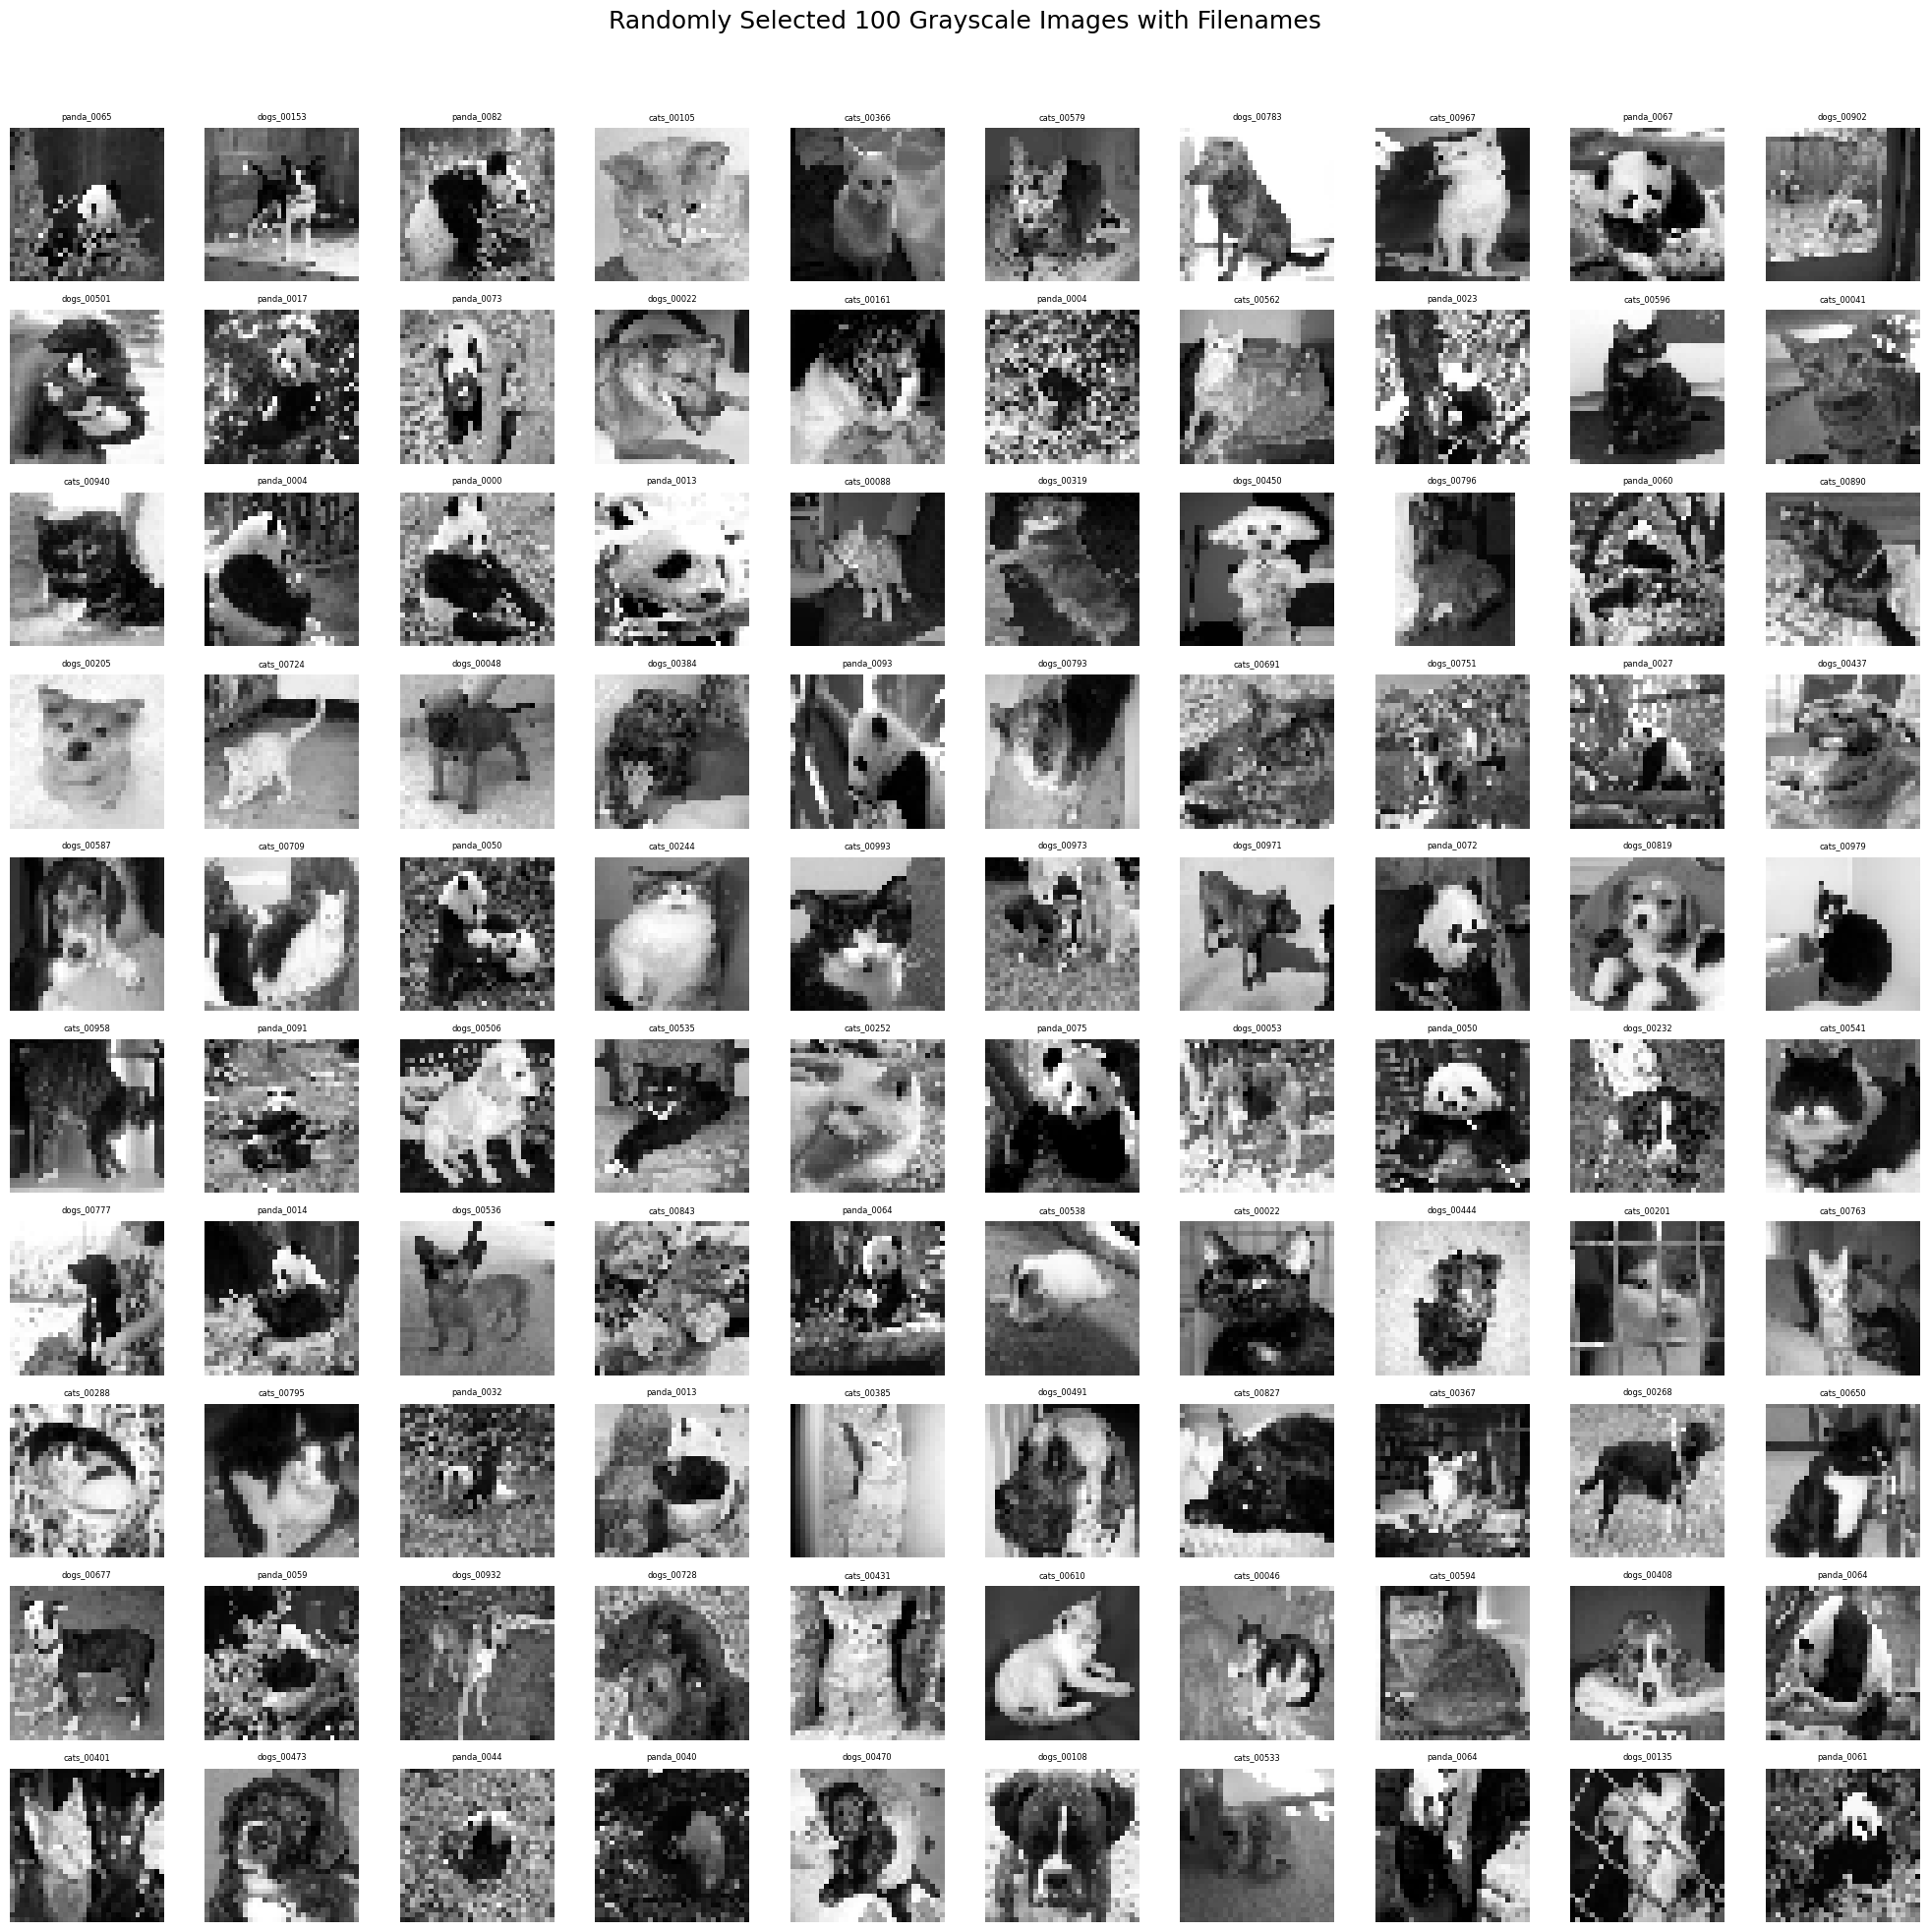

Total images processed: 100


In [23]:
#  DISPLAY THE 100 GRAYSCALE IMAGES
plt.figure(figsize=(20, 20))
for i in range(len(display_data)):
    img, _, name = display_data[i]
    plt.subplot(10, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(name[:10], fontsize=6)  # Truncate name for readability
    plt.axis('off')

plt.suptitle("Randomly Selected 100 Grayscale Images with Filenames", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

print("Total images processed:", len(features))

In [24]:


# Manhattan Distance (L1)
def manhattan_distance(vec1, vec2):
   
    return np.sum(np.abs(vec1 - vec2))

# Euclidean Distance (L2)
def euclidean_distance(vec1, vec2):
   
    return np.sqrt(np.sum((vec1 - vec2) ** 2))



It zips features and labels into a single list, then shuffles it to ensure randomness. The data is split into 5 equal folds for cross-validation, with any leftover items if the total isn't divisible by   distributed one by one into the first few folds. Finally, it prints the size of each fold to verify the distribution.


In [25]:
# Combine features and labels into data list
data = list(zip(features, labels))  # Each item: (feature_vector, label)

#  Shuffle the data
random.shuffle(data)

#  Create 5 folds
fold_size = len(data) // 5
folds = [data[i * fold_size : (i + 1) * fold_size] for i in range(5)]

#  (Optional) Distribute any remaining items due to rounding
remainder = len(data) % 5
for i in range(remainder):
    folds[i].append(data[5 * fold_size + i])

#  Print fold sizes for verification
for i, fold in enumerate(folds):
    print(f"Fold {i+1} size:", len(fold))


Fold 1 size: 20
Fold 2 size: 20
Fold 3 size: 20
Fold 4 size: 20
Fold 5 size: 20


This code shuffles and splits the dataset into 5 folds for cross-validation, evenly distributing the data and handling any leftovers. It then prints the size of each fold to ensure balanced partitioning.

In [26]:
from collections import Counter

def knn_predict(X_train, y_train, x_test, k=7, distance_type='l2'):
    distances = []
    for i in range(len(X_train)):
        if distance_type == 'l1':
            dist = manhattan_distance(X_train[i], x_test)
        else:
            dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    
    # Sort by distance
    distances.sort(key=lambda x: x[0])

   
    k_labels = [label for _, label in distances[:k]]

    # Majority vote
    most_common = Counter(k_labels).most_common(1)
    return most_common[0][0]



In [27]:
def run_knn_cross_validation(folds, k_values, distance_type='l2'):
    fold_wise_accuracies = []

    for fold_index in range(5):
        # Prepare validation and training sets
        validation_data = folds[fold_index]
        training_data = []
        for i in range(5):
            if i != fold_index:
                training_data.extend(folds[i])

        # Separate features and labels
        X_train = np.array([item[0] for item in training_data])
        y_train = np.array([item[1] for item in training_data])
        X_val = np.array([item[0] for item in validation_data])
        y_val = np.array([item[1] for item in validation_data])

        fold_accuracies = []

        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, distance_type=distance_type)
                if pred == y_val[i]:
                    correct += 1
            accuracy = (correct / len(X_val)) * 100
            fold_accuracies.append(accuracy)

        fold_wise_accuracies.append(fold_accuracies)

    avg_accuracies = np.mean(fold_wise_accuracies, axis=0)
    return fold_wise_accuracies, avg_accuracies


The dataset is evaluated using the K-Nearest Neighbors (KNN) algorithm with 5-fold cross-validation, following these steps:

In each iteration, one of the five folds is used as the validation set, while the other four are combined to form the training set.

Features and labels are extracted separately for both training and validation datasets.

For every fold, the KNN classifier is tested with K values ranging from 1 to 30.

For each K, the algorithm calculates the distance between each validation sample and all training samples using either Manhattan (L1) or Euclidean (L2) distance.

These distances are sorted in ascending order for each validation sample.

The predicted class is determined through majority voting among the K closest neighbors.

Accuracy for each K value in the current fold is computed and stored.

All fold-specific accuracies are collected in a fold_accuracies list.

The entire procedure is executed separately for both distance metrics (Manhattan and Euclidean).



In [28]:
def evaluate_knn(distance_func, label=""):
    k_best = 3
    y_true_all = []
    y_pred_all = []

    for fold_index in range(5):
        validation_set = Folds[fold_index]
        training_set = [item for i, fold in enumerate(Folds) if i != fold_index for item in fold]

        for val_img, val_label in validation_set:
            distances = [(distance_func(val_img, train_img), train_label)
                         for train_img, train_label in training_set]
            pred = knn_predict(distances, k_best)
            y_true_all.append(val_label)
            y_pred_all.append(pred)

    print(f"\nResults for {label}:")
    classification_report(y_true_all, y_pred_all, num_classes=len(CATEGORIES))
    confusion_matrix(y_true_all, y_pred_all, num_classes=len(CATEGORIES))


The graph showed that accuracy generally improved as K increased, up to a point. After that, the performance either flattened out or slightly dropped. This is expected — using more neighbors can help reduce noise, but too many can blur the decision.

The graph also let us compare L1 and L2 distances to see which one worked better overall.

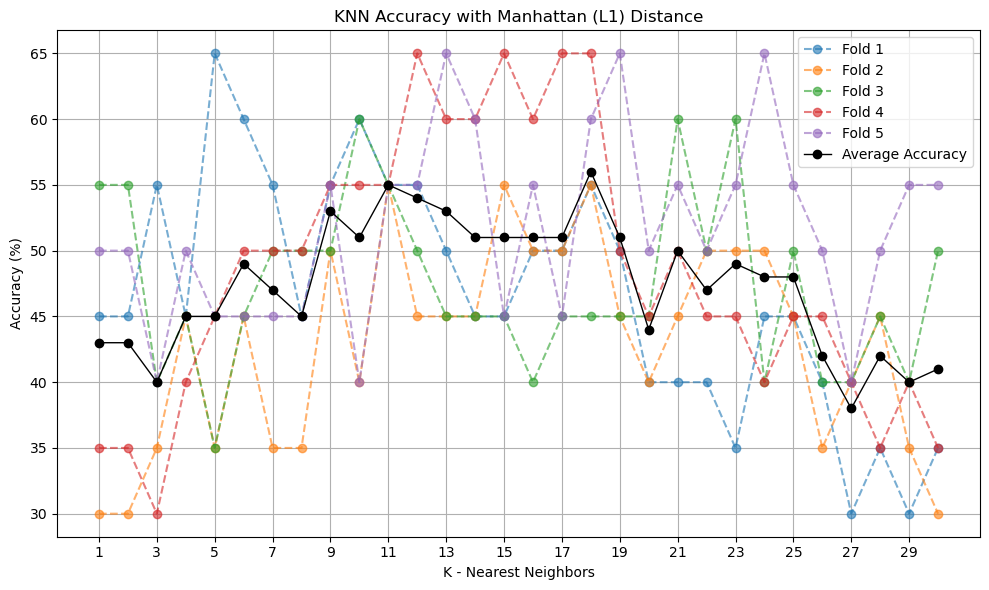

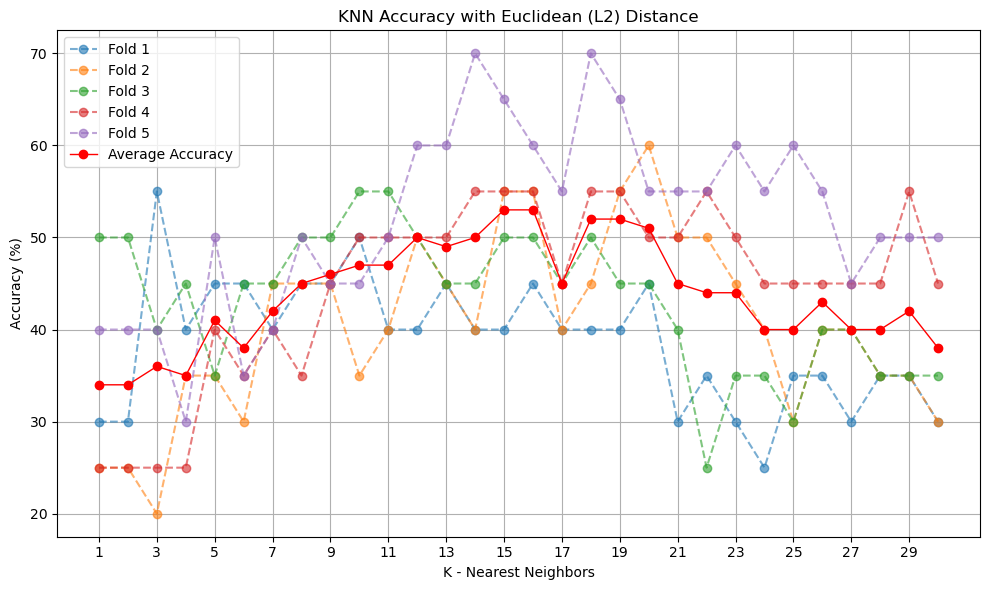

In [29]:
K_values = np.arange(1, 31)

# Run cross-validation for both distances
fold_acc_l1, avg_acc_l1 = run_knn_cross_validation(folds, K_values, distance_type='l1')
fold_acc_l2, avg_acc_l2 = run_knn_cross_validation(folds, K_values, distance_type='l2')

# Function to plot fold-wise and average accuracy
def plot_knn_accuracy(K, fold_accuracies, avg_accuracies, title, color):
    plt.figure(figsize=(10, 6))

    # Plot each fold’s accuracy
    for i, acc in enumerate(fold_accuracies):
        plt.plot(K, acc, 'o--', label=f'Fold {i+1}', alpha=0.6)

    # Plot average accuracy
    plt.plot(K, avg_accuracies, 'o-', color=color, label='Average Accuracy', linewidth=1)

    plt.xlabel("K - Nearest Neighbors")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(1, 31, 2))
    plt.tight_layout()
    plt.show()


# Plot both distances
plot_knn_accuracy(K_values, fold_acc_l1, avg_acc_l1, "KNN Accuracy with Manhattan (L1) Distance", color='black')
plot_knn_accuracy(K_values, fold_acc_l2, avg_acc_l2, "KNN Accuracy with Euclidean (L2) Distance", color='red')


In [30]:

# Show average accuracy for Manhattan (L1) distance
print("Average Accuracy for Manhattan (L1) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l1[i]:.2f}%")

print("\nAverage Accuracy for Euclidean (L2) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l2[i]:.2f}%")


Average Accuracy for Manhattan (L1) Distance:
K =  1 : 43.00%
K =  2 : 43.00%
K =  3 : 40.00%
K =  4 : 45.00%
K =  5 : 45.00%
K =  6 : 49.00%
K =  7 : 47.00%
K =  8 : 45.00%
K =  9 : 53.00%
K = 10 : 51.00%
K = 11 : 55.00%
K = 12 : 54.00%
K = 13 : 53.00%
K = 14 : 51.00%
K = 15 : 51.00%
K = 16 : 51.00%
K = 17 : 51.00%
K = 18 : 56.00%
K = 19 : 51.00%
K = 20 : 44.00%
K = 21 : 50.00%
K = 22 : 47.00%
K = 23 : 49.00%
K = 24 : 48.00%
K = 25 : 48.00%
K = 26 : 42.00%
K = 27 : 38.00%
K = 28 : 42.00%
K = 29 : 40.00%
K = 30 : 41.00%

Average Accuracy for Euclidean (L2) Distance:
K =  1 : 34.00%
K =  2 : 34.00%
K =  3 : 36.00%
K =  4 : 35.00%
K =  5 : 41.00%
K =  6 : 38.00%
K =  7 : 42.00%
K =  8 : 45.00%
K =  9 : 46.00%
K = 10 : 47.00%
K = 11 : 47.00%
K = 12 : 50.00%
K = 13 : 49.00%
K = 14 : 50.00%
K = 15 : 53.00%
K = 16 : 53.00%
K = 17 : 45.00%
K = 18 : 52.00%
K = 19 : 52.00%
K = 20 : 51.00%
K = 21 : 45.00%
K = 22 : 44.00%
K = 23 : 44.00%
K = 24 : 40.00%
K = 25 : 40.00%
K = 26 : 43.00%
K = 27 : 40

Euclidean distance worked slightly better when K was small. This makes sense because it measures the actual geometric distance between images, which fits well with our grayscale image data.

Manhattan distance was more stable for larger values of K. It's less sensitive to outliers, which might help in noisy or less consistent data.

In [31]:
# Create a new list combining features and labels manually
data = []
for i in range(len(features)):
    data.append([features[i], labels[i]])

# Shuffle the combined data
random.shuffle(data)

# Split into 80% training and 20% testing
split = int(0.8 * len(data))
train = data[:split]
test = data[split:]

# Separate features and labels for training
train_x = []
train_y = []
for item in train:
    train_x.append(item[0])
    train_y.append(item[1])

# Separate features and labels for testing
test_x = []
test_y = []
for item in test:
    test_x.append(item[0])
    test_y.append(item[1])

# Convert to numpy arrays
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)


In [32]:
def get_accuracy(train_x, train_y, test_x, test_y, k=3, dist_type='l2'):
    correct = 0
    for i in range(len(test_x)):
        pred = knn_predict(train_x, train_y, test_x[i], k=k, distance_type=dist_type)
        if pred == test_y[i]:
            correct += 1
    return (correct / len(test_y)) * 100

In [33]:
k = 5  # K-value to test

# L1 Distance (Manhattan)
train_acc_l1 = get_accuracy(train_x, train_y, train_x, train_y, k, 'l1')
test_acc_l1 = get_accuracy(train_x, train_y, test_x, test_y, k, 'l1')

# L2 Distance (Euclidean)
train_acc_l2 = get_accuracy(train_x, train_y, train_x, train_y, k, 'l2')
test_acc_l2 = get_accuracy(train_x, train_y, test_x, test_y, k, 'l2')

# Print results
print(f"L1 - Train Accuracy: {train_acc_l1:.2f}%")
print(f"L1 - Test Accuracy : {test_acc_l1:.2f}%")
print("---")
print(f"L2 - Train Accuracy: {train_acc_l2:.2f}%")
print(f"L2 - Test Accuracy : {test_acc_l2:.2f}%")


L1 - Train Accuracy: 75.00%
L1 - Test Accuracy : 50.00%
---
L2 - Train Accuracy: 68.75%
L2 - Test Accuracy : 45.00%


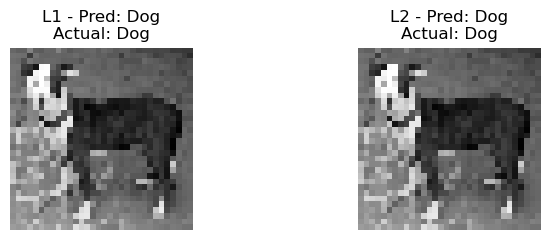

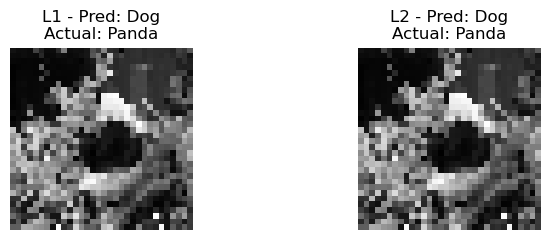

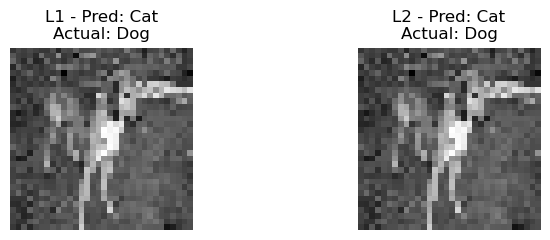

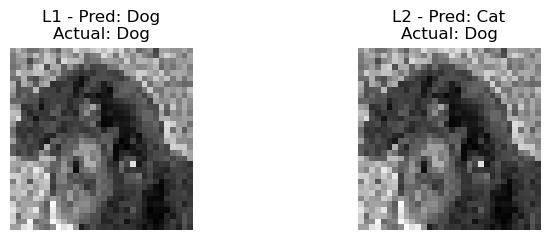

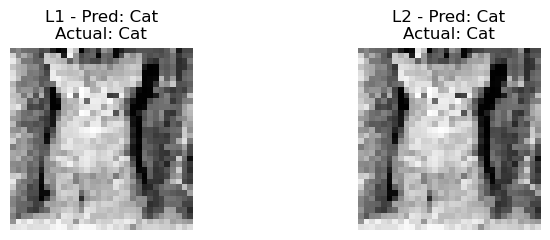

In [34]:
# Step 1: Split data (already done above)
split_index = int(0.8 * len(features))
X_train, X_test = features[:split_index], features[split_index:]
y_train, y_test = labels[:split_index], labels[split_index:]

# Class names
class_names = ['Cat', 'Dog', 'Panda']

# Step 2: Prediction and visualization for both L1 and L2
def show_top_5_predictions(X_train, y_train, X_test, y_test, class_names, k=7):
    for i in range(5):
        img = X_test[i].reshape(32, 32)
        
        pred_l1 = knn_predict(X_train, y_train, X_test[i], k=k, distance_type='l1')
        pred_l2 = knn_predict(X_train, y_train, X_test[i], k=k, distance_type='l2')
        
        # Plot side-by-side
        plt.figure(figsize=(8, 2.5))

        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"L1 - Pred: {class_names[pred_l1]}\nActual: {class_names[y_test[i]]}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img, cmap='gray')
        plt.title(f"L2 - Pred: {class_names[pred_l2]}\nActual: {class_names[y_test[i]]}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Call the function
show_top_5_predictions(X_train, y_train, X_test, y_test, class_names, k=7)


To test how well my KNN model works, i have changed the number of neighbors (K) from 1 to 10 and measured how accurate the model was in each case. i used  used 5-fold cross-validation, which means the model was trained and tested multiple times on different parts of the data so that every image got a chance to be in the test set.

I tested the model using two distance types:

Manhattan Distance (L1): adds up all the absolute pixel differences

Euclidean Distance (L2): takes the square root of the sum of squared pixel differences

For each distance type, I averaged the accuracy across the 5 folds and plotted it to see how accuracy changed with different values of K.

Limitations
as I  only used 100 images, which is quite small for an image classification task.All images were resized to 32×32, which may have removed small details important for classification.
i used raw pixel values without any feature extraction (like edges or textures).KNN can be computationally expensive for large datasets since it calculates the distance between every test and training sample. Also, it is sensitive to the scale of data and irrelevant features, which may affect prediction accuracy.





 How to Improve
To make the model better in future versions:

Use more images , make distance comparisons more meaningful.Future work can also involve testing the model on larger and more complex datasets or comparing KNN with other classification algorithms for better performance.

In this project, the KNN algorithm was successfully implemented with 5-fold cross-validation to evaluate classification accuracy using both Manhattan and Euclidean distances. The results showed how the choice of K and distance metric can significantly impact model performance. However, the method has some limitations. KNN can be computationally expensive for large datasets since it calculates the distance between every test and training sample. Also, it is sensitive to the scale of data and irrelevant features, which may affect prediction accuracy. To improve this, feature selection or dimensionality reduction methods like PCA can be applied before training. Moreover, using optimized data structures like KD-Trees or Ball Trees can speed up distance computation. Future work can also involve testing the model on larger and more complex datasets or comparing KNN with other classification algorithms for better performance.